<a href="https://colab.research.google.com/github/hyeonjusong410/DL.Basic/blob/main/Attention_in_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, dim_input, dim_recurrent, dim_output):
        super(RNN, self).__init__()
        self.fc_x2h = nn.Linear(dim_input, dim_recurrent)
        self.fc_h2h = nn.Linear(dim_recurrent, dim_recurrent, bias=False)
        self.fc_h2y = nn.Linear(dim_recurrent, dim_output)
        self.relu = nn.ReLU()


        nn.init.xavier_normal_(self.fc_x2h.weight)
        nn.init.xavier_normal_(self.fc_h2h.weight)
        nn.init.xavier_normal_(self.fc_h2y.weight)

    def forward(self, x, h_t=None):
        N = x.shape[1]
        D = self.fc_h2h.weight.shape[0]

        if h_t is None:
            h_t = torch.zeros(1, N, D, dtype=torch.float32)


        h = []

        for x_t in x:
            h_t = self.relu(self.fc_x2h(x_t.unsqueeze(0)) + self.fc_h2h(h_t))
            h.append(h_t)

        all_h = torch.cat(h, dim=0)
        all_y = self.fc_h2y(all_h)
        return all_y, all_h

In [4]:
def generate_batch(seq_len_min=1, seq_len_max=20, batch_size=10):
    T_1 = np.random.randint(seq_len_min, seq_len_max + 1)
    digits = np.random.randint(0, 10, (T_1, batch_size))
    one_hot_x = np.zeros((T_1 + 1, batch_size, 12), dtype=np.float32)
    one_hot_x[np.arange(T_1).reshape(-1, 1), np.arange(batch_size), digits] = 1
    one_hot_x[-1, :, -1] = 1
    ends = np.full(batch_size, 11).reshape(1, -1)
    y = np.concatenate([digits[::-1], ends], axis=0)
    return one_hot_x, y, digits

In [6]:
def one_hot_encode_prediction(y_t):

    y_t = y_t.detach().cpu().numpy()
    max_values_mask = (y_t == y_t.max(axis=-1, keepdims=True))
    one_hot_encoded = torch.tensor(max_values_mask.astype(np.float32), dtype=torch.float32)
    return one_hot_encoded

In [8]:
# input
y_t = [[[0.1, 0.5, 0.3, 0.1],
        [0.2, 0.1, 0.6, 0.1],
        [0.5, 0.4, 0.1, 0.0]]]

max_values_mask = [[[False, True, False, False],
                    [False, False, True, False],
                    [True, False, False, False]]]

# output
one_hot_encoded = torch.tensor([[[0.0, 1.0, 0.0, 0.0],
                                 [0.0, 0.0, 1.0, 0.0],
                                 [1.0, 0.0, 0.0, 0.0]]])



In [9]:
# setup
T = 10  # encoder에 들어가는 input sequence의 길이(length)
N = 32  # batch size
D = 18  # dimension of hidden state
encoder_hidden_states = torch.randn(T, N, D)

### attention score

In [10]:
## H^eW_a = W_\alpha @ H^e
W_alpha = nn.Linear(D, D)
precomputed_encoder_score_vectors = W_alpha(encoder_hidden_states)
# (T, N, D) @ (D, D) -> (T, N, D)

In [11]:
print("precomputed_encoder_score_vectors shape:", precomputed_encoder_score_vectors.shape)


precomputed_encoder_score_vectors shape: torch.Size([10, 32, 18])


In [12]:
h_t = torch.randn(1, N, D)

In [14]:
e_t = (precomputed_encoder_score_vectors * h_t).sum(dim=-1)
print("e_t shape (element-wise multiplication and sum):", e_t.shape)

e_t shape (element-wise multiplication and sum): torch.Size([10, 32])


#### attention weight

In [15]:
a_t = F.softmax(e_t, dim = 0)
print("a_t shape:", a_t.shape)

a_t shape: torch.Size([10, 32])


In [16]:
a_t[..., None].shape

torch.Size([10, 32, 1])

#### context vector

In [18]:
## context vector = {\alpha_j * {h_j}^e}의 가중합
c_t = (a_t[..., None] * encoder_hidden_states).sum(dim=0, keepdim=True)
# (T, N, 1) * (T, N, D) -> (T, N, D).sum(axis=0, keepdims=True) -> (1, N, D)
c_t.shape

torch.Size([1, 32, 18])

In [19]:
K = 12  # dim_output in decoder (RNN)
y_t = torch.randn(1, N, K)

# concat context vector & decoder output
y_and_c = torch.cat([y_t, c_t], dim=-1)  # (1, N, K), (1, N, D) -> (1, N, K+D)
print("y_and_c shape:", y_and_c.shape)

y_and_c shape: torch.Size([1, 32, 30])


In [20]:
post_concat_dense = nn.Linear(K + D, K)
y_t = post_concat_dense(y_and_c)
print("y_t shape: ", y_t.shape)

y_t shape:  torch.Size([1, 32, 12])


### seq2seq with attention

In [21]:
class Attentionseq2seq(nn.Module):
    def __init__(self, dim_input, dim_recurrent, dim_output):
        super(Attentionseq2seq, self).__init__()

        self.encoder = RNN(dim_input, dim_recurrent, dim_output)
        self.decoder = RNN(dim_input, dim_recurrent, dim_output)
        self.W_alpha = nn.Linear(dim_recurrent, dim_recurrent, bias=False)
        self.post_concat_dense = nn.Linear(dim_recurrent + dim_output, dim_output)

        nn.init.xavier_normal_(self.W_alpha.weight)
        nn.init.xavier_normal_(self.post_concat_dense.weight)

    def forward(self, x):

        T, N, C = x.shape
        _, enc_h = self.encoder(x)
        h_t = enc_h[-1:]
        y = []
        s_t = torch.zeros((1, N, C), dtype=torch.float32)
        s_t[..., -2] = 1

        precomputed_encoder_score_vectors = self.W_alpha(enc_h)

        a_ij = []

        for _ in range(T):

            e_t = (precomputed_encoder_score_vectors * h_t).sum(dim=-1)
            a_t = F.softmax(e_t, dim=0)
            a_ij.append(a_t.unsqueeze(0))
            c_t = (a_t[..., None] * enc_h).sum(dim=0, keepdim=True)
            y_t, h_t = self.decoder(s_t, h_t)
            y_and_c = torch.cat([y_t, c_t], dim=-1)
            y_t = self.post_concat_dense(y_and_c)
            y.append(y_t)
            s_t = one_hot_encode_prediction(y_t)
        y = torch.cat(y, dim=0)  # y: shape-(T, N, K)
        a_ij = torch.cat(a_ij, dim=0) # a_ij: shape-(T, T, N)

        return y, a_ij


In [22]:
model = Attentionseq2seq(12, 25, 12)
optimizer = optim.Adam(model.parameters())

In [23]:
from IPython.display import clear_output
def plot_all(losses, acces):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Loss')
    plt.plot(acces, label='acc')
    plt.xlabel('Batches (It must multiple x 1000)')
    plt.ylabel('Loss and Acc')
    plt.title('Loss and Acc Averages over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

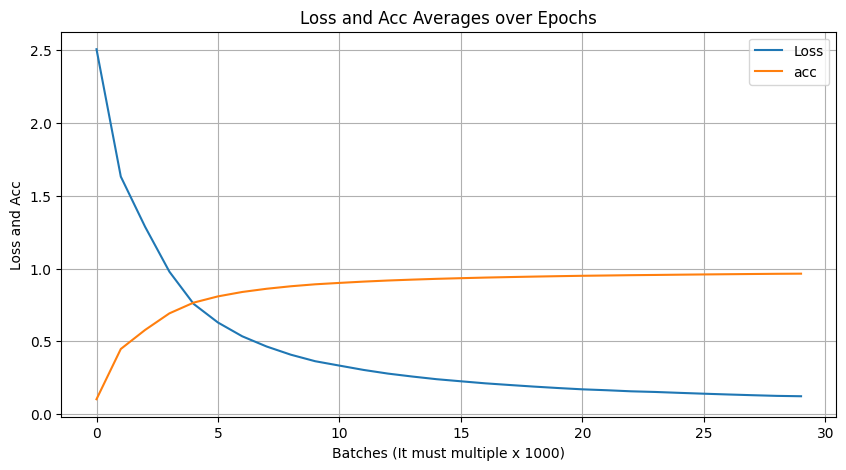

loss: 0.12213946408073843, accuracy: 0.964683752203178


In [24]:
batch_size = 100
num_batches = 30000

loss_ = []
acc_ = []
loss_average_list = []
acc_list_average = []
for k in range(num_batches):
    x, target, sequence = generate_batch(batch_size=batch_size)

    x_tensor = torch.tensor(x, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.long)

    optimizer.zero_grad()
    output, _ = model(x_tensor)

    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(output.reshape(-1, 12), target_tensor.reshape(-1))
    loss.backward()
    optimizer.step()

    acc = (output.argmax(dim=-1) == target_tensor).float().mean().item()

    loss_.append(loss.item())
    acc_.append(acc)
    if k % 1000 == 0:
        acc_average = np.mean(acc_)
        loss_average = np.mean(loss_)
        loss_average_list.append(loss_average)
        acc_list_average.append(acc_average)
        plot_all(loss_average_list, acc_list_average)
        print(f"loss: {loss_average}, accuracy: {acc_average}")